# Liver analysis 001

**Date**: 2020-09-19<br>
**Author**: Alma Andersson<br>
**Description**:<br>

Analysis of a single liver sample, mainly to illustrate certain concepts and show what sort of analysis that can be made. The analysis include plotting of gene expression levels as a function of distance from a vein (of a given type), classification of veins based on their surrounding gene expression, and a survey of how the spot expression compares to certain types of tissue.



## Setup

Load data the necessary packages and data for the analysis, also specify certain constants which will be used throughout the analysis.

In [10]:
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os.path as osp
from os import listdir

import matplotlib.pyplot as plt

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist


In [11]:
#specify path to h5ad object (prepared with prep-data.py)
data_pth = "/tmp/design.h5ad"
# specify path to folder where gene lists are kept
gene_list_pth = "/home/alma/w-projects/help/franzi/rsc/gene-lists/veins"

In [12]:
# read data
data = ad.read_h5ad(data_pth)

In [13]:
# read gene lists
genes = dict()
for filename in listdir(gene_list_pth):
    name = '.'.join(filename.split(".")[0:-1])
    with open(osp.join(gene_list_pth,filename),"r+") as f:
        _gs = f.readlines()
        _gs = [x.replace("\n","") for x in _gs]
        genes.update({name:_gs})
        
# create an additional entry called "all" by joining 
# all existing lists
genes["all"] = reduce(lambda x,y : x + y,list(genes.values()))

In [14]:
# CONSTANTS

# RADIUS: maximal distance between spots in a neighborhood of a vein
# and the vein itself
RADIUS = 100

# TYPES: vein types in the data
TYPES = np.unique(data.uns["mask"]["type"])

Visualize the data to make sure everything looks as expected

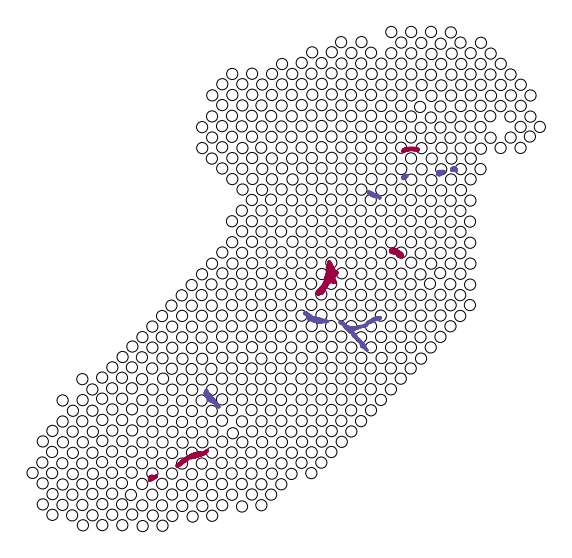

In [15]:
# set to true if spots should be
# colored by distance to nearest vein
show_all_spots = False
# set to true if neighboorhoods
# should be plotted
show_nbrhood = False

# vein type to use as reference
# for distances and neighborhoods
vein_type = "central"


# instatiate figure
fig,ax = plt.subplots(1,
                      1,
                      figsize = (10,10))

# plot spot outlines
ax.scatter(data.obs["x"].values,
           data.obs["y"].values,
           c = "none",
           edgecolor = "black",
           s = 125,
           )

# plot neighborhood
if show_nbrhood:
    ax.scatter(data.obs["x"].values[clr < RADIUS],
                data.obs["y"].values[clr < RADIUS],
                c = "red",
               alpha = 0.5,
               s = 120,
               )

# color spots by distance
if show_all_spots:
    ax.scatter(data.obs["x"].values,
                data.obs["y"].values,
                c = clr,
               s = 120,
               cmap = plt.cm.YlOrBr_r,
               alpha = 0.5
               )


# map to go form categorical value
# to integer, needed for plotting
_cti = {v:k for k,v in \
        enumerate(np.unique(data.uns["mask"]["type"].values))}
cti = np.vectorize(lambda x : _cti[x])
                                 
# plot veins
ax.scatter(data.uns["mask"]["x"].values,
            data.uns["mask"]["y"].values,
            c = cti(data.uns["mask"]["type"].values),
            s = 2,
            cmap = plt.cm.Spectral_r,
           )

ax.invert_yaxis()
ax.axis("off")

plt.show()

## Analysis : Expression by distance

Model gene expression as a function of the distance to the nearest gene. We use loess regression to get an approximation of the curve that describe the trends in the data. Envelopes (blue) represent 1 standard error.

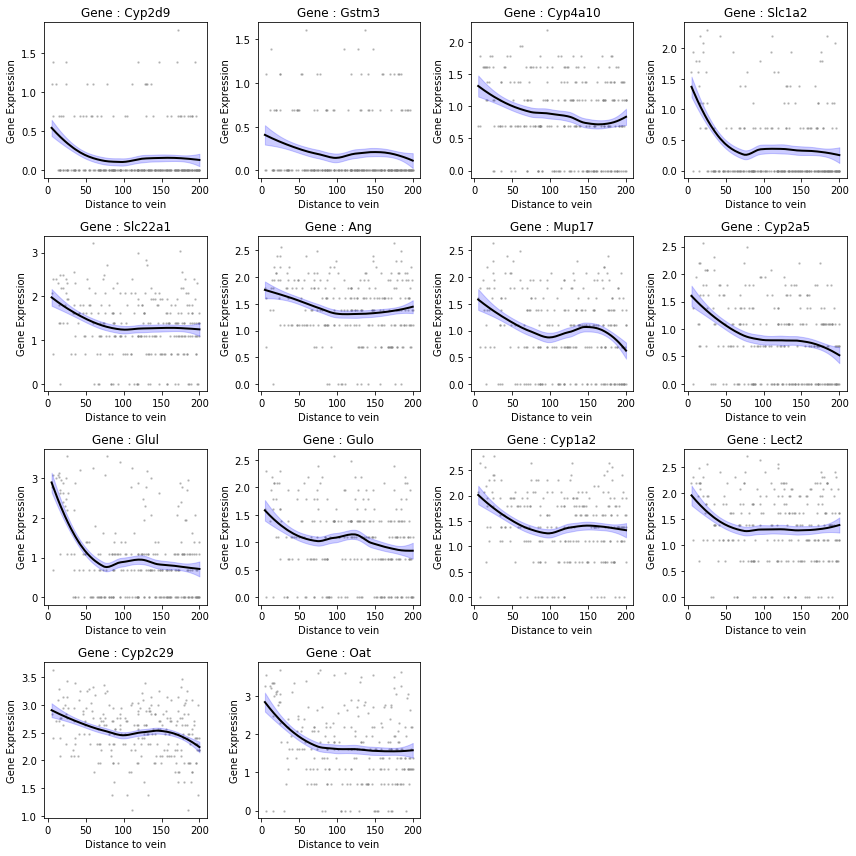

In [16]:

# set vein type to plot
vein_type = "central"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 200

# which genes to be assessed
vein_genes = genes[vein_type]

# distance values to use
min_dist = data.obsm["vein_distances"]["dist_type_" + vein_type].values

# plot setup ---
n_cols = 4
n_rows = int(np.ceil(len(vein_genes)/n_cols))
figsize = (n_cols * 3,
           n_rows * 3)

fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = figsize)
ax = ax.flatten()
# --- plot settings

# get indices of sorted distances
srt = np.argsort(min_dist)
# select distances to plot
keep_dist = min_dist[srt] < dist_thrs

max_y = 0

# iterate over each gene
for k,gene in enumerate(vein_genes):
    
    # get distances (sorted)
    xs = min_dist[srt][keep_dist]
    # get observed exression values
    ys = data.obs_vector(gene)[srt][keep_dist]
    
    # generate loess class object
    ls = loess(xs,
               ys,
              )
    # fit loess class to data
    ls.fit()
    
    # predict on data
    pred =  ls.predict(xs,
                       stderror=True)
    # get predicted values
    ys_hat = pred.values
    # get standard error
    stderr = pred.stderr
    
    # plot observed expression values
    ax[k].scatter(xs,
                  ys,
                  s = 2,
                  c = "gray",
                  alpha = 0.4,
                 )
    
    # plot standard error
    ax[k].fill_between(xs,
                       ys_hat - stderr,
                       ys_hat + stderr,
                       alpha = 0.2,
                       color = "blue",
                      )
    
    # plot loess approximation
    ax[k].plot(xs,
               ys_hat,
               c = "black",
               linewidth = 2,
              )

    # add info to plots
    ax[k].set_title("Gene : {}".format(gene))
    ax[k].set_ylabel("Gene Expression")
    ax[k].set_xlabel("Distance to vein")
    
    # update highest observed y-value
    max_y = np.max((max_y,ax[k].get_ylim()[1]))

# adjust y-axis if set to share
if share_y:
    for aa in ax:
        aa.set_ylim([0,max_y])
    
# remove unused subplots
for n in range(k,n_cols*n_rows):
    ax[n].set_visible(False)
    
fig.tight_layout()

## Analysis : Classification

Begin by assembling representative (mean expression) vectors for neighborhoods around respective vein type and each individual vein. Then proceed to train a predictor (Logistic Regression) and see how it performs on the given data (this is just a prototype).

### Prepare data
Create the necessary mean expression profiles

In [17]:
# set variables for ease of access
vein_data = data.uns["mask"]
data_crd = data.obs[["x","y"]].values

# dictionary for label conversion
_id_to_type = {}
# list tp hold individual veins average 
# expression levels
vein_expr = list()
# list to hold types' average
# expression levels
type_expr = {k:[] for k in TYPES}

# iterate over all individual veins
for vein in np.unique(vein_data["id"]):
    # get index of vein members in the mask-data
    pos = vein_data["id"] == vein
    # get type of vein
    vc = vein_data["type"][pos].values[0]
    
    # update mapping between id and type
    _id_to_type.update({vein:vc})
    
    # get coordinates of specific vein
    vein_crd = vein_data[["x","y"]].\
               values[pos,:]
    
    # compute distances for spots
    # to pixels in specific vein
    dmat = cdist(data_crd,
                 vein_crd)
    
    # get minimum distances
    dmat = np.min(dmat,axis = 1)
    
    # get indices of spots
    # within specified radius
    in_box = dmat < RADIUS
    
    # get average expression for 
    # neighborhood of vein
    x_vein = np.mean(data.to_df().loc[in_box,genes["all"]],
                     axis = 0)
    
    # store average expression
    vein_expr.append(x_vein)
    # add expression (non-averaged) to expression
    # of associated vein type
    type_expr[vc].append(data.to_df().loc[in_box,:].values)
    

# function to map vein id to type
id_to_type = np.vectorize(lambda x: _id_to_type[x])


# assemble individual vein expression df
vein_expr = pd.DataFrame(vein_expr,
                         columns = genes["all"],
                         index = np.unique(vein_data["id"]))

# assemble type vein expression df
type_expr = pd.DataFrame(np.array([np.concatenate(x).mean(axis = 0) for x \
                                   in type_expr.values()]),
                         index = list(type_expr.keys()),
                         columns = data.var.index,
                        )

print("vein mean expression vectors:".capitalize())
display(vein_expr)
print("type mean expression vectors:".capitalize())
display(type_expr)

Vein mean expression vectors:


,Cyp2f2,Hal,Hsd17b13,Sds,Ctsc,A1bg,Aldh1b1,Pck1,Spp1,Cyp2d9,...,Ang,Mup17,Cyp2a5,Glul,Gulo,Cyp1a2,Lect2,Cyp2c29,Oat,Aldh1a1
0,1.406763,1.473106,1.132855,0.486764,1.101666,0.880285,0.297785,0.683218,0.159957,0.213276,...,1.226424,0.643924,0.795776,0.704574,0.780023,0.992861,0.842402,2.498719,1.253801,2.293590
1,1.394905,1.562580,0.963838,0.486764,1.026217,0.942664,0.297785,0.767727,0.159957,0.266595,...,1.367049,0.728433,0.941709,0.769751,0.949040,1.038075,1.067879,2.605836,1.410818,2.414034
2,1.522242,1.418201,1.021253,0.497036,1.078325,1.031182,0.244466,0.924544,0.000000,0.213276,...,1.449610,0.843175,0.882470,1.049933,1.026217,1.169209,1.130688,2.512679,1.594750,2.472730
3,1.255608,1.154847,0.986038,0.433986,0.817673,1.021540,0.200070,0.689351,0.000000,0.186944,...,1.407037,1.219953,1.180837,1.399305,1.176477,1.415703,1.393209,2.615859,2.129320,2.530177
4,1.167705,1.188418,0.727195,0.253575,0.503564,1.047905,0.281954,0.491167,0.108106,0.099542,...,1.697968,1.096294,1.235206,1.417908,1.076727,1.681853,1.516817,2.593400,2.145506,2.583493
5,1.191499,1.072282,1.103993,0.323083,0.622186,0.800708,0.254331,0.464070,0.000000,0.250429,...,1.652155,1.329348,1.116101,1.524323,1.213269,1.692601,1.574528,2.710472,2.151051,2.527093
6,1.119905,1.065630,0.755920,0.334532,0.461266,0.538279,0.167266,0.598250,0.000000,0.188606,...,1.664221,1.552274,1.061418,1.111241,1.396616,1.814509,1.657061,2.751780,2.163185,2.614256
7,1.304082,1.176465,1.039801,0.524067,0.798887,0.915541,0.177493,0.757472,0.148532,0.148532,...,1.505040,0.700435,0.618478,0.931301,0.952029,1.405666,1.259296,2.643044,1.587739,2.685129
8,2.190651,1.746875,1.223933,1.126385,1.264793,1.219323,0.618478,0.976950,0.663060,0.099021,...,1.035998,0.454008,0.572453,0.724104,0.503518,1.062264,0.866031,2.050524,1.093590,1.807634
9,1.685474,1.378280,1.029286,0.749578,0.863808,1.113301,0.307344,0.719352,0.274557,0.063013,...,1.298951,0.745504,0.646195,0.912008,0.687129,1.292763,1.096372,2.342618,1.467851,2.287468


Type mean expression vectors:


,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Gm24276,Rrs1,Adhfe1,Vcpip1,...,Syap1,Ctps2,Pir,Mospd2,Rab9,Tmsb4x,Prps2,Msl3,Arhgap6,Hccs
central,0.499719,1.016269,0.063538,0.234975,0.358579,0.369791,0.040434,0.046210,0.561738,0.214268,...,0.367734,0.047191,0.160319,0.192579,0.404014,0.861359,0.078470,0.145387,0.028881,0.169474
portal,0.496669,0.965173,0.075668,0.312326,0.278537,0.330084,0.075668,0.087344,0.436736,0.252380,...,0.280573,0.046086,0.153359,0.308119,0.447792,0.989682,0.115525,0.136855,0.041259,0.095596


In [18]:
# add an (average) expression vector
# for types not in neigborhood of any vein
# these are called "normal" spots
no_nbr_spt = np.any(data.obsm["vein_distances"].values > RADIUS,
                    axis = 1)

no_nbr_spt = data.to_df().iloc[no_nbr_spt,:]
no_nbr_spt = no_nbr_spt.mean()
no_nbr_spt.name = "normal"
type_expr = type_expr.append(no_nbr_spt)

print("_Updated_ type mean expression vectors:".capitalize())
display(type_expr)

_updated_ type mean expression vectors:


,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Gm24276,Rrs1,Adhfe1,Vcpip1,...,Syap1,Ctps2,Pir,Mospd2,Rab9,Tmsb4x,Prps2,Msl3,Arhgap6,Hccs
central,0.499719,1.016269,0.063538,0.234975,0.358579,0.369791,0.040434,0.046210,0.561738,0.214268,...,0.367734,0.047191,0.160319,0.192579,0.404014,0.861359,0.078470,0.145387,0.028881,0.169474
portal,0.496669,0.965173,0.075668,0.312326,0.278537,0.330084,0.075668,0.087344,0.436736,0.252380,...,0.280573,0.046086,0.153359,0.308119,0.447792,0.989682,0.115525,0.136855,0.041259,0.095596
normal,0.477055,1.012324,0.052432,0.200297,0.249721,0.294146,0.045338,0.049460,0.477683,0.263571,...,0.303759,0.057683,0.170613,0.260062,0.372775,0.996413,0.081581,0.149926,0.044288,0.122718


### Train and Predict with classifier

use the `LogisticRegression` module from `sklearn` to create a classifier (binary classification into portal and central veins). We use a l2 penalty to reduce the extent of overfitting and also prevent the weights to blow up.

In [19]:
from sklearn.linear_model import LogisticRegression as LR

In [20]:
# Instatiate and fit classifier, use
# random seed for reproducibility
clf = LR(random_state = 1337,
         penalty = "l2")\
     .fit(vein_expr.values,
          id_to_type(vein_expr.index.values)
          )

In [21]:
# predict on training data
pred = clf.predict(vein_expr.values)
# get accuracy of prediction
acc = np.array([x == y for x,y in \
                zip(pred,
                    id_to_type(vein_expr.index.values))]).\
                    astype(np.float)

# print prediction result
print("Prediction accuracy : {:0.3f} | Correct {:0.0f}/{:0.0f} veins".format(acc.sum() / len(acc),
                                                             acc.sum(),
                                                             len(acc),
                                                            ))

Prediction accuracy : 0.917 | Correct 11/12 veins


Visualize the result in UMAP-space; inner circle is predicted type, outer circle is true type

/home/alma/.local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


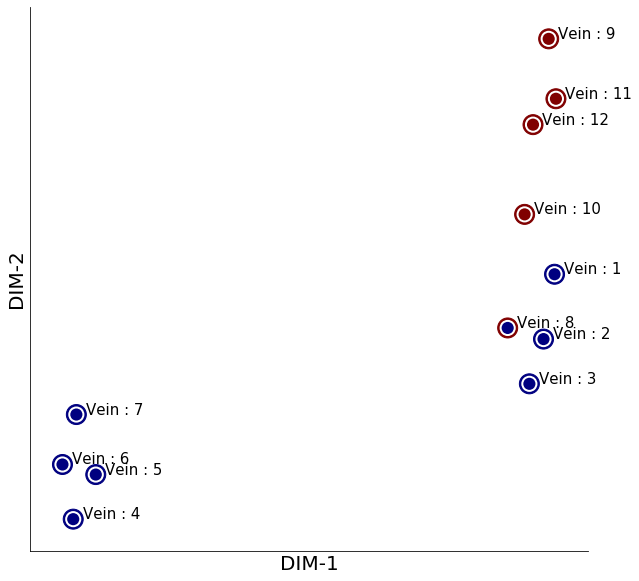

In [22]:
# import umap module
import umap

# instatiate figure and plot
fig,ax = plt.subplots(1,
                      1,
                      figsize = (10,10))

# marker size
UMAP_MARKER_SIZE = 400

# perform UMAP dimred
dr = umap.UMAP(n_components = 2,
               n_neighbors=4,
               random_state= 2).fit_transform(vein_expr.values)


# function to map category to integer number
# usef for plotting
_cti = {n:k for k,n in enumerate(type_expr.index)}
cat_to_int  = np.vectorize(lambda x: _cti[x])

# plot true type labels
ax.scatter(dr[:,0],
           dr[:,1],
           c = cat_to_int(id_to_type(vein_expr.index.values)),
           cmap = plt.cm.jet,
           s = UMAP_MARKER_SIZE,
           )

# plot predicted type labels
ax.scatter(dr[:,0],
            dr[:,1],
            c = cat_to_int(pred),
            cmap = plt.cm.jet,
            s = UMAP_MARKER_SIZE * 0.5,
           edgecolor = "white",
           linewidth = 2,
          )


# plot vein names
for ii in range(dr.shape[0]):
    ax.text(dr[ii,0] + 0.2,dr[ii,1],
            s = "Vein : {}".format(ii+1),
            fontsize = 15,
           )

# adjust which axes are displayed
for p in ["top","right"]:
    ax.spines[p].set_visible(False)

# cleanup plots
ax.set_ylabel("DIM-2",fontsize = 20)
ax.set_xlabel("DIM-1",fontsize = 20)
ax.set_yticks([])
ax.set_xticks([])

plt.show()

In [23]:
def maptoid(idx : np.ndarray,
            val_to_map : np.ndarray,
            val_id : np.ndarray,
           )-> np.ndarray:
    
    """ map labels to vein coordinates
    
    Parameters:
    -----------
    
    idx : np.ndarray
        M-dimensional vector with 
        vein id of each pixel constituting
        mask.
    val_to_map : np.ndarray
        values to assign veins
    val_id : np.ndarray
        ids of veins to which
        values in val_to_map should
        be assinged
        
    Returns:
    --------
    M-dimensional vector
    where val_to_map values
    have been assigned to each
    mask pixel.
        
    
    """
    
    assert len(val_to_map) == len(val_id),\
        "val_to_map and val_id must be of"\
        " equal length."
    
    new_val = np.zeros(idx.shape,
                       dtype = object)
    
    
    for v,i in zip(val_to_map,val_id):
        pos = idx == i
        new_val[pos] = v
    
    return new_val
        

Finally we can visualize the prediction on the tissue, showing the predicted and true labels for respective vein

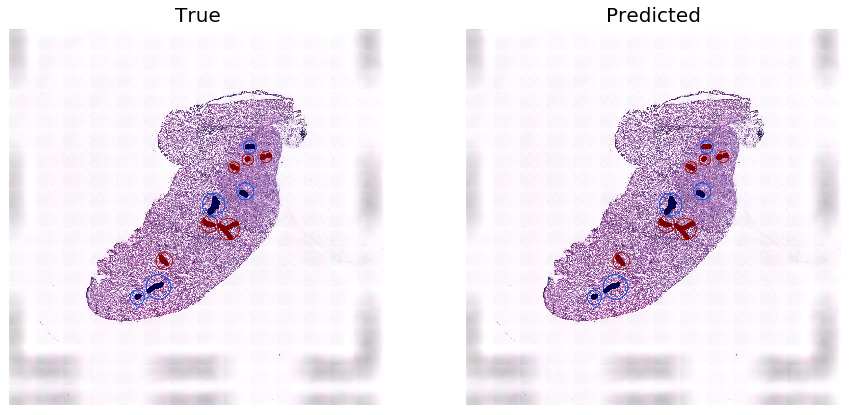

In [24]:
# instantiate plot
fig,ax = plt.subplots(1,2,
                      figsize = (15,15))

# convert predicted type to vector
# with label for each pixel
cpred = maptoid(data.uns["mask"]["id"].values,
                pred,
                vein_expr.index)

# in-place function for vein plot
vein_plot = lambda axx,c : axx.scatter(data.uns["mask"]["x"],
                                       data.uns["mask"]["y"],
                                       c = c,
                                       s = 5, 
                                       cmap = plt.cm.seismic_r,
                                      )

# plot HE-image and remove axes
for aa in ax: 
    aa.axis("off")
    aa.imshow(data.uns["img"])

# plot veins with true type
vein_plot(ax[0],
          cat_to_int(data.uns["mask"]["type"].values))

# plot veins with predicted type
vein_plot(ax[1],
          cat_to_int(cpred))

# set titles
ax[0].set_title("True",
                fontsize = 20,)
ax[1].set_title("Predicted",
                fontsize = 20,)



plt.show()

## Show spot similarity with average expression profiles

See which of the expression profiles (portal, central, normal) that each spot is most similar to. Use the expression profiles constituted by the genes specified by `sel`, similarity is based on the angle ($\theta$) in expression space.

In [25]:
# genes to include in analysis
sel = data.var.index

# prepare score matrix
score = pd.DataFrame(np.zeros((data.X.shape[0],
                               type_expr.shape[0])),
                     index = data.obs.index,
                     columns = type_expr.index,
                    )

# get expression for selected genes
nX = data.to_df().loc[:,sel]

# get l2-norm of each expression vector
lX = np.linalg.norm(nX,
                    axis = 1,
                    keepdims = True)

# convert all expression vectors to unit-vectors
nX = nX / lX

# mapper between score values and type
_score_to_type = dict()

# iterate over each type of vein
for k,tp in enumerate(type_expr.index):

    # get mean expression vector for type
    lV = np.linalg.norm(type_expr.loc[tp,sel].values,
                        keepdims = True)
    
    # convert mean expression vector to unit-vector
    nV = type_expr.loc[tp,sel].values / lV
    
    # compute angle between vectors
    theta = np.arccos(np.dot(nX,nV))
    
    # store angle value  
    score.loc[:,tp] = theta
    # update mapper
    _score_to_type[k] = tp
    
# vectorize mapper
score_to_type = np.vectorize(lambda x: _score_to_type[x])

# add similarity score to obs attribute
data.obs["sim_score"] = score_to_type(np.argmin(score.values,axis = 1))

Plot the spots and color them w.r.t. which type of mean expression vector they are most similar to

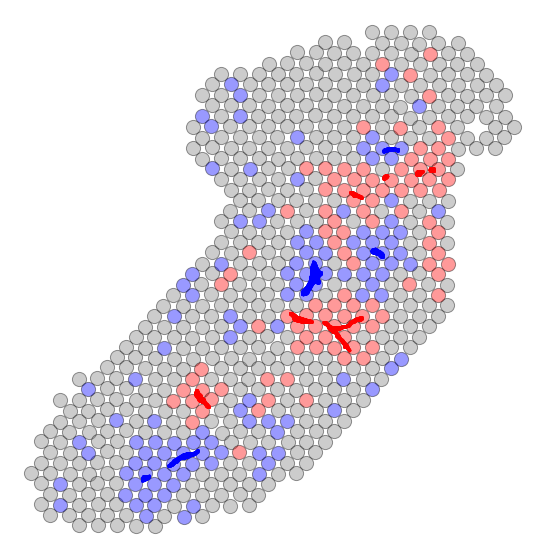

In [26]:

# instatiate plot
fig,ax = plt.subplots(1,1,figsize = (10,10))

# colormap
cmap = dict(normal = "gray",
            portal = "blue",
            central = "red")

# iterate over different types
for tp in cmap.keys():
    
    # select spots most similar to type
    sel_data = (data.obs["sim_score"] == tp)
    
    # plot selected spots
    ax.scatter(data.obs["x"][sel_data],
               data.obs["y"][sel_data],
               c = cmap[tp],
               cmap = plt.cm.jet,
               edgecolor = "black",
               alpha = 0.4,
               s = 200,
               marker = "o",
               )

    # select pixels belonging to veings of type
    sel_mask = (data.uns["mask"]["type"] == tp)
    
    # plot selected pixels (veins)
    ax.scatter(data.uns["mask"]["x"].values[sel_mask],
               data.uns["mask"]["y"].values[sel_mask],
               c = cmap[tp],
               s = 2,
               cmap = plt.cm.jet,
               )
    
    ax.set_aspect("equal")
    ax.axis("off")
    ax.invert_yaxis()

plt.show()